## This is a project using LSTM recurrent neural network, for practice and learing only!

## This project is really fun for a business background person
#### We expected more epochs and more data may increase the accuray. However, if we compare "20000 days/ 10 epoch" and "3000 days/ 1 epoch", the latter one present better accuracy.
#### I believe one of the reason is, after the 2008 financial crisis, the Fed knew how to stimulate the market, so the market has been acting as a different way. Therefore, the more data you use to train before that period, the more bias will get into model
#### With NUM_DAYS = 20000 and epochs = 1, we get lowest rmse. Which means that the data during 20000 and 3000 still be helpful

### import library and fetch data

In [1]:
import tensorflow as tf 
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

import warnings
warnings.filterwarnings("ignore")

In [2]:
NUM_DAYS = 3000    # The number of days of historical data to retrieve
# NUM_DAYS = 20000     # Another number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = '^GSPC'   # Symbol of the desired stock

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

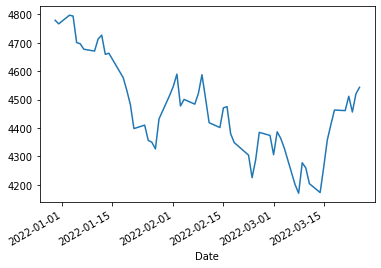

In [3]:
start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
# start2 = (datetime.date.today() - datetime.timedelta( NUM_DAYS2 ) )
end = datetime.datetime.today()

# get yfinance data
data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
# data2 = yf.download(symbol, start=start2, end=end, interval=INTERVAL)
tmp = data.iloc[-60:]
tmp['Adj Close'].plot()
# data2

In [4]:
# save data so no need to call API everytime 
data.to_csv(r'S&P_data')

In [5]:
# prepare training and testing data
data = data.filter(['Adj Close'])
dataset = data.values
train_len = math.ceil(len(dataset) * 0.75)

# scaler = prep.MinMaxScaler(feature_range=(0,1))
scaler = prep.StandardScaler()
scaled_data = scaler.fit_transform(dataset)

scaled_data.shape

(2069, 1)

In [6]:
train_data = scaled_data[0:train_len , : ]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [7]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
print (x_train.shape)

# make the data acceptable to LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print (x_train.shape)

(1492, 60)
(1492, 60, 1)


In [8]:
# build lstm model
# but need to maxmize chips on m1 machine first

tf.config.set_visible_devices([], 'GPU') #hide GPU, this line make the training process more than 20x faster on Apple M1 mac 

cpus = tf.config.experimental.list_physical_devices('CPU')
# print(cpus)
tf.config.set_visible_devices(cpus[0], 'CPU') # unhide potentially hidden CPU
tf.config.get_visible_devices()

model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = "adam", loss = "mean_squared_error")

In [9]:
# train 
model.fit(x_train, y_train, batch_size = 1, epochs =1 )
# model.fit(x_train, y_train, batch_size = 1, epochs =10 ) use for 20000 days model

1492/1492 [==============================] - 30s 20ms/step - loss: 0.0049


In [10]:
# prepare test dataset
test_data = scaled_data[train_len - 60: , : ]

x_test = []
y_test = dataset[train_len : , :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])

In [11]:
# convert to np array and make it lstm acceptable
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [12]:
#  get predieted value
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [13]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

255.3474479985191

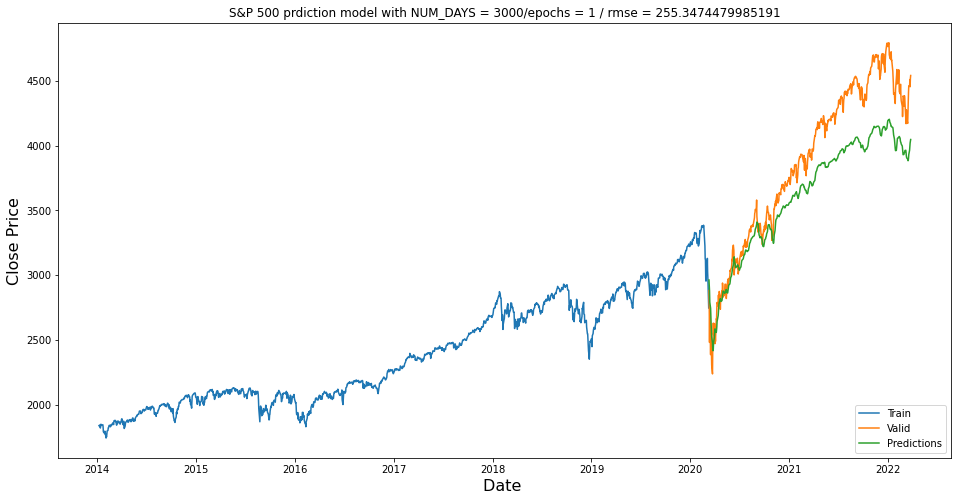

In [14]:
# show the chart 
train = data[:train_len]
valid = data[train_len:]

valid["Predictions"] = predictions
train

plt.figure(figsize = (16,8))
plt.title("S&P 500 prdiction model with NUM_DAYS = " + str(NUM_DAYS) +"/epochs = 1 / rmse = " + str(rmse))
plt.xlabel("Date ", fontsize = 16)
plt.ylabel('Close Price', fontsize = 16 )
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()


## This model trained with more data and more epochs

### Below is the chart for NUM_DAY = 20000, epochs = 1

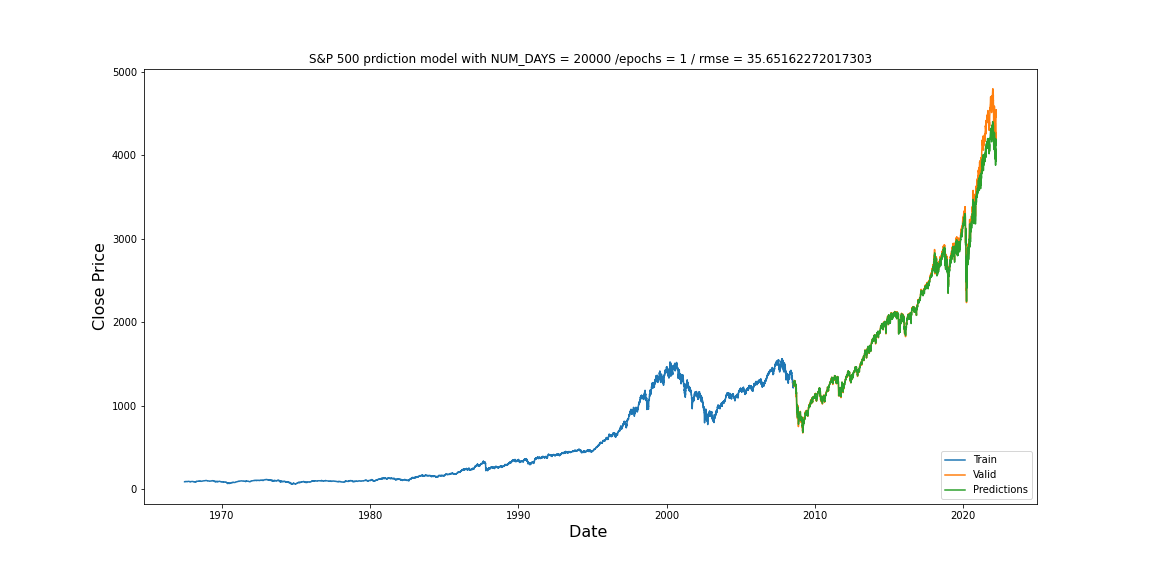

In [16]:
from IPython.display import Image
Image(filename='20000_1.png') 

### Below is the chart for NUM_DAY = 20000, epochs = 10

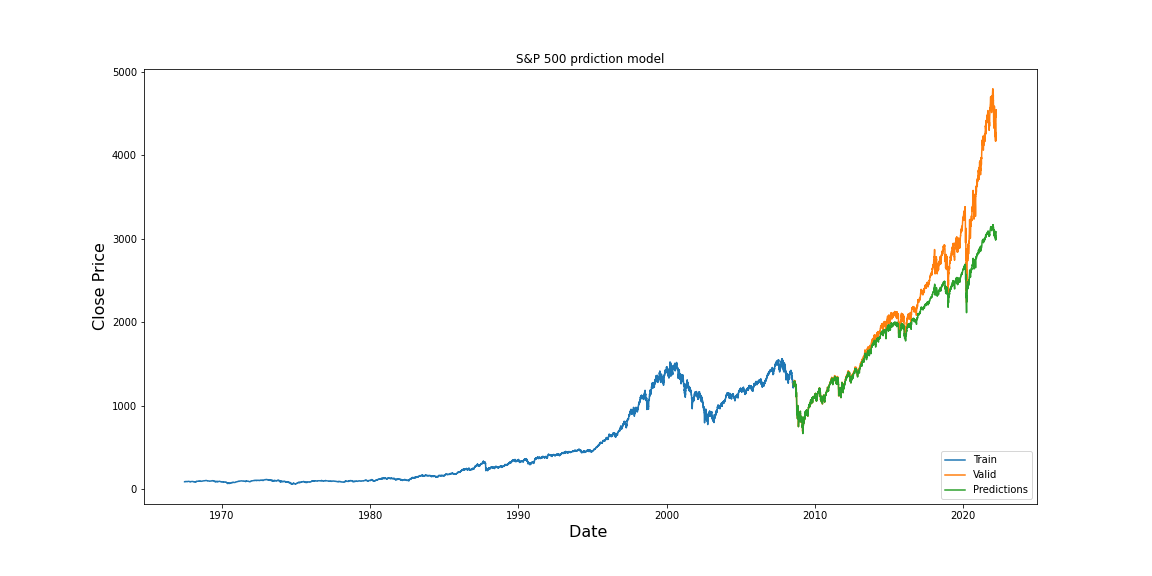

In [15]:
from IPython.display import Image
Image(filename='20000_10.png') 